In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
class Arm:
    def __init__(self, p):
        self.p = p
    
    def pull(self):
        return np.random.binomial(1, self.p)

class MultiBandit:
    def __init__(self, probs = [0.1, 0.2, 0.7, 0.5]):
        self.__arms = [Arm(p) for p in probs]
        self.__regret = 0
        self.__maxp = max(probs)

    def num_arms(self):
        return len(self.__arms)

    def pull(self, arm_num):
        reward = self.__arms[arm_num].pull()
        self.__regret += self.__maxp-self.__arms[arm_num].p
        return reward
    
    def regret(self):
        return self.__regret

In [26]:
class EpsilonGreedyAlgorithm:
    def __init__(self, num_arms, horizon, epsilon):
        # Initialize our algorithm
        self.num_arms = num_arms                    # Number of arms present in the bandit
        self.horizon = horizon                      # Total Horizon of the algorithm
        self.epsilon = epsilon                      # epsiolon value for the algorithm
        self.timestep = 0                           # The current timestep while running the algorithm
        self.arm_pulls = np.zeros(num_arms)         # History of number of times each arm was pulled
        self.arm_rewards = np.zeros(num_arms)       # History of the total reward accumulated by each arm
        self.regrets = np.zeros(horizon)            # Total regret at each timestep of the horizon

    def give_best_arm(self):
        # Return the arm which the algorithm considers to be the best arm at end of algorithm
        if np.sum(self.arm_pulls) == 0:
            return 0
        empirical_mean = np.divide(self.arm_rewards, self.arm_pulls,
                                   out =np.zeros_like(self.arm_rewards),
                                   where = self.arm_pulls !=0)
        return np.argmax(empirical_mean)
        # empirical mean for each arm
    

    def select_arm(self):
        # Select arm at each time step. You are supposed to return the index of which 
        # arm has been selected to pull at this timestep
        if np.random.random() < self.epsilon: # explore; chose random arm
            return np.random.randint(self.num_arms)
        else: # exploit; chosing arm with highest empirical mean
            if np.sum(self.arm_pulls) == 0:
                return 0
            empirical_mean = np.divide(self.arm_rewards, self.arm_pulls,
                                       out=np.zeros_like(self.arm_rewards),
                                       where =self.arm_pulls != 0)
            return np.argmax(empirical_mean)
        

    def run_algorithm(self, bandit):
        # This is the proper algorithm. Already completed
        for _ in range(self.horizon):
            arm_to_pull = self.select_arm()             # Select the arm using the algorithm
            reward = bandit.pull(arm_to_pull)           # Pull the arm and find our the reward
            self.arm_pulls[arm_to_pull] += 1            # Update the arm pull count and arm reward count
            self.arm_rewards[arm_to_pull] += reward
            self.timestep += 1                          # Update the timestep
            self.regrets[_] = bandit.regret()           # Store the regret values at each timestep
    
    def plot(self):
        # Plot the regret graph. Label the X and Y Axis properly using matplotlib library
        plt.figure(figsize=(10,6))
        plt.plot(range(1, self.horizon+1), self.regrets, 'b-', linewidth=2, label='E-Greedy')
        plt.xlabel('time steps')
        plt.ylabel('cumulative regret')
        plt.title(f'Epsilon-Greedy Algorithm')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.show()

Total Regret after 100 timesteps: 6.8999999999999995 with assumed best arm 2


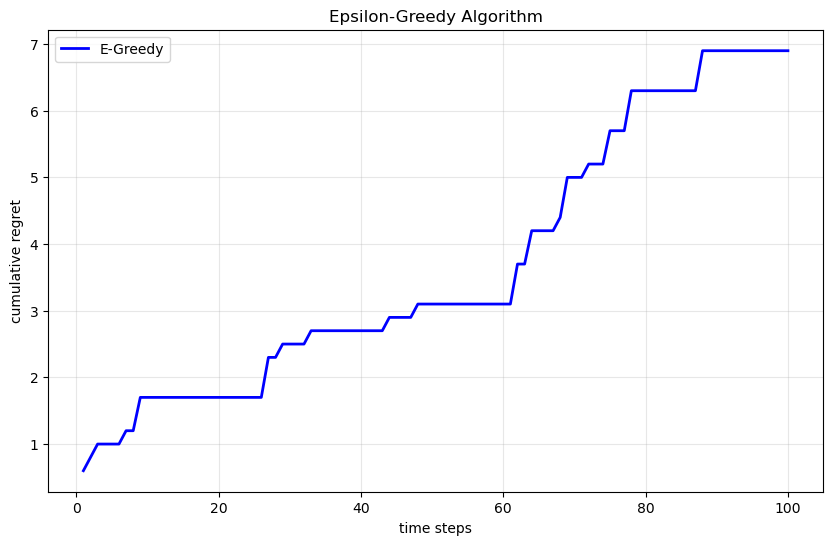

In [27]:
# Define a MultiBandit instance
bandit = MultiBandit()
# bandit = MultiBandit([0.1, 0.5, 0.8, 0.3, 0.4])   # Make custom Multi-armed Bandit. Should work while grading code

# Set the horizon size
H = 100

# Create  Algorithm instance
algorithm = EpsilonGreedyAlgorithm(num_arms=bandit.num_arms(), horizon=H, epsilon=0.2)

# Run the algorithm
algorithm.run_algorithm(bandit)

# Display total regret
print(f"Total Regret after {H} timesteps: {bandit.regret()} with assumed best arm {algorithm.give_best_arm()}")
algorithm.plot()

In [28]:
class UCB:
    def __init__(self, num_arms, horizon, c=2):
        self.num_arms = num_arms 
        self.horizon = horizon 
        self.c = c # confidence parameter
        self.timestep = 0
        self.arm_pulls = np.zeros(num_arms)
        self.arm_rewards = np.zeros(num_arms)
        self.regrets = np.zeros(horizon)

    
    def give_best_arm(self):
        if np.sum(self.arm_pulls) == 0:
            return 0
        empirical_mean = np.divide(self.arm_rewards, self.arm_pulls,
                                   out=np.zeros_like(self.arm_rewards),
                                   where=self.arm_pulls != 0)
        return np.argmax(empirical_mean)

    def select_arm(self):
        #if any arm hasnt pulled, pull it first
        for i in range(self.num_arms):
            if self.arm_pulls[i]== 0:
                return i
        # ucb values
        empirical_mean = (self.arm_rewards)/ (self.arm_pulls)
        confidence_bounds = (np.sqrt((self.c *np.log(self.timestep+1)))) /(self.arm_pulls)
        ucb_value = empirical_mean + confidence_bounds
        return np.argmax(ucb_value)

    
    def run_algorithm(self, bandit):
        for _ in range(self.horizon):
            arm_to_pull = self.select_arm()             # Select the arm using the algorithm
            reward = bandit.pull(arm_to_pull)           # Pull the arm and find our the reward
            self.arm_pulls[arm_to_pull] += 1            # Update the arm pull count and arm reward count
            self.arm_rewards[arm_to_pull] += reward
            self.timestep += 1                          # Update the timestep
            self.regrets[_] = bandit.regret()           # Store the regret values at each timestep
    def plot(self):
        plt.figure(figsize=(10,6))
        plt.plot(range(1, self.horizon+1), self.regrets, 'r-', linewidth=2, label='UCB')
        plt.xlabel('time steps')
        plt.ylabel('cumulative regret')
        plt.title(f'Upper Confidence Bound Algorithm')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.show()
        

In [31]:
class TSA: # thompson sampling algo
    def __init__(self, num_arms, horizon, alpha_prior=1, beta_prior=1):
        self.num_arms = num_arms                    # Number of arms present in the bandit
        self.horizon = horizon                      # Total Horizon of the algorithm
        self.timestep = 0                           # The current timestep while running the algorithm
        self.arm_pulls = np.zeros(num_arms)         # History of number of times each arm was pulled
        self.arm_rewards = np.zeros(num_arms)       # History of the total reward accumulated by each arm
        self.regrets = np.zeros(horizon)            # Total regret at each timestep of the horizon
      # beta dist parameters for thompson sampling
        self.alpha = np.full(num_arms, alpha_prior) # success parameter
        self.beta = np.full(num_arms, beta_prior) # failure parameter
    def give_best_arm(self):
        if np.sum(self.arm_pulls) == 0:
            return 0
        
        empirical_means = np.divide(self.arm_rewards, self.arm_pulls, 
                                  out=np.zeros_like(self.arm_rewards), 
                                  where=self.arm_pulls!=0)
        return np.argmax(empirical_means)
        
    def select_arm(self):
        # sample from beta dist for each arm
        sampled_values = np.random.beta(self.alpha, self.beta)
        return np.argmax(sampled_values)

    
    def run_algorithm(self, bandit):
        for _ in range(self.horizon):
            arm_to_pull = self.select_arm()             # Select the arm using the algorithm
            reward = bandit.pull(arm_to_pull)           # Pull the arm and find our the reward
            self.arm_pulls[arm_to_pull] += 1            # Update the arm pull count and arm reward count
            self.arm_rewards[arm_to_pull] += reward
            self.timestep += 1                          # Update the timestep
            self.regrets[_] = bandit.regret()           # Store the regret
            

            # update beta dist parameters
            if reward == 1:
                self.alpha[arm_to_pull] +=1
            else:
                self.beta[arm_to_pull] += 1
    def plot(self):
        plt.figure(figsize=(10,6))
        plt.plot(range(1, self.horizon+1), self.regrets, 'g-', linewidth=2, label='UCB')
        plt.xlabel('time steps')
        plt.ylabel('cumulative regret')
        plt.title(f'Thompson Sampling Algorithm')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.show()      

## execution code

In [34]:
def test_algo():
    # diff horizons
    horizons = [500, 100, 2000]
    for H in horizons:
        # test epsilon-greedy
        bandit = MultiBandit([0.1, 0.2, 0.7, 0.5])
        eps_alg = EpsilonGreedyAlgorithm(bandit.num_arms(), H, 0.1)
        eps_alg.run_algorithm(bandit)
        print(f"E-Greedy: Regret = {bandit.regret():.4f}, Best Arm = {eps_alg.give_best_arm()}")

        # test ucb
        bandit = MultiBandit([0.1, 0.2, 0.7, 0.5])
        ucb_alg = UCB(bandit.num_arms(), H, 2)
        ucb_alg.run_algorithm(bandit)
        print(f"UCB: Regret = {bandit.regret():.4f}, Best Arm = {ucb_alg.give_best_arm()}")
        # test thompson sampling
        bandit = MultiBandit([0.1, 0.2, 0.7, 0.5])
        ts_alg = TSA(bandit.num_arms(), H)
        ts_alg.run_algorithm(bandit)
        print(f"Thompson: Regret = {bandit.regret():.4f}, Best Arm = {ts_alg.give_best_arm()}")

test_algo()

E-Greedy: Regret = 28.4000, Best Arm = 2
UCB: Regret = 8.9000, Best Arm = 2
Thompson: Regret = 12.3000, Best Arm = 2
E-Greedy: Regret = 10.2000, Best Arm = 2
UCB: Regret = 9.9000, Best Arm = 2
Thompson: Regret = 4.7000, Best Arm = 2
E-Greedy: Regret = 88.1000, Best Arm = 2
UCB: Regret = 13.0000, Best Arm = 2
Thompson: Regret = 16.3000, Best Arm = 2


## evaluation block

Custom Bandit Probabilities: [0.2, 0.6, 0.9, 0.3, 0.1]
True Optimal Arm: 2

-- RESULTS --
Epsilon-Greedy: Regret = 97.9000, Best Arm = 2
UCB: Regret = 14.5000, Best Arm = 2
Thompson Sampling: Regret = 9.9000, Best Arm = 2

BEST Algorithm: Thompson Sampling
WORST Algorithm: Epsilon-Greedy


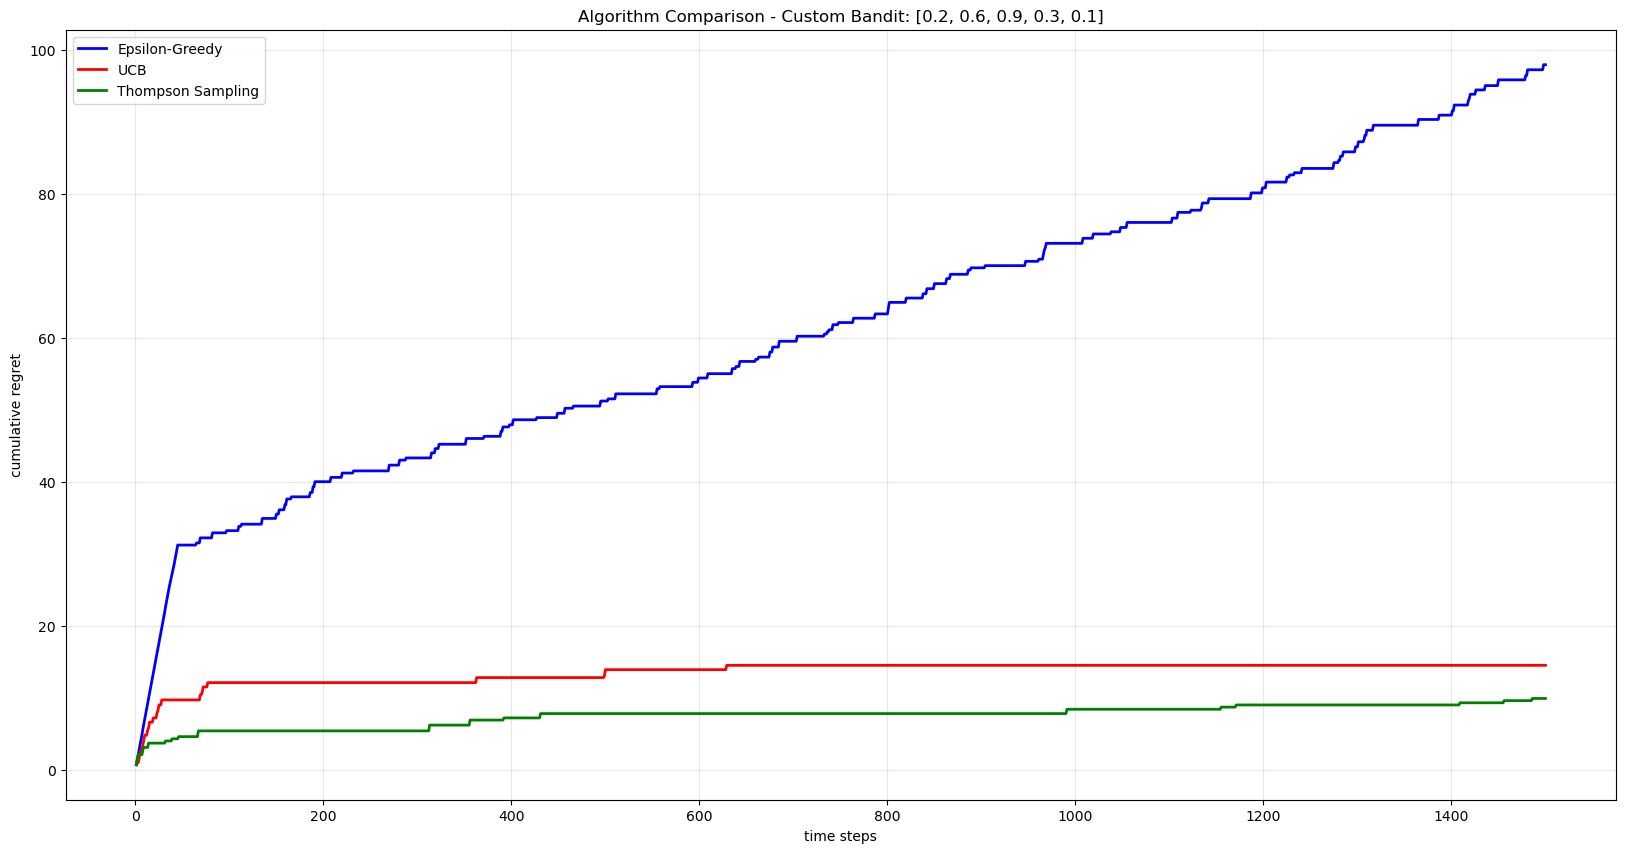

In [38]:
def evaluation_block():
    
    # customize prob values
    custom_probs = [0.2, 0.6, 0.9, 0.3, 0.1]
    H = 1500
    print(f"Custom Bandit Probabilities: {custom_probs}")
    print(f"True Optimal Arm: {np.argmax(custom_probs)}")
    
    # creating separate bandit instances
    bandit1 = MultiBandit(custom_probs)
    bandit2 = MultiBandit(custom_probs)
    bandit3 = MultiBandit(custom_probs)
    
    # initializing algorithms
    eps_greedy = EpsilonGreedyAlgorithm(bandit1.num_arms(), H, 0.1)
    ucb = UCB(bandit2.num_arms(), H, 2)
    thompson = TSA(bandit3.num_arms(), H)

    # run
    eps_greedy.run_algorithm(bandit1)
    ucb.run_algorithm(bandit2)
    thompson.run_algorithm(bandit3)

    # print results
    algorithms = [eps_greedy, ucb, thompson]
    bandits = [bandit1, bandit2, bandit3]
    names = ["Epsilon-Greedy", "UCB", "Thompson Sampling"]
    
    print("\n-- RESULTS --")
    final_regrets = []
    for alg, bandit, name in zip(algorithms, bandits, names):
        regret = bandit.regret()
        best_arm = alg.give_best_arm()
        final_regrets.append(regret)
        print(f"{name}: Regret = {regret:.4f}, Best Arm = {best_arm}")

    # best and worst
    best_idx = np.argmin(final_regrets)
    worst_idx = np.argmax(final_regrets)
    print(f"\nBEST Algorithm: {names[best_idx]}")
    print(f"WORST Algorithm: {names[worst_idx]}")

    # plot comparision
    plt.figure(figsize=(20, 10))
    colors = ['blue', 'red', 'green']
    for i, (alg, name, color) in enumerate(zip(algorithms, names, colors)):
        plt.plot(range(1, H+1), alg.regrets, color=color, linewidth=2, label=name)
    
    plt.xlabel('time steps')
    plt.ylabel('cumulative regret')
    plt.title(f'Algorithm Comparison - Custom Bandit: {custom_probs}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
# run the evaluation
evaluation_block()